Import all of the libraries you need to use

In [ ]:
from google.colab import drive
import pandas as pd
import sklearn
import numpy as np
import os
import re
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
import statistics
import seaborn as sb
import matplotlib.pyplot as plt

!pip install geopandas
import geopandas as gpd

# Mount drive to access files
drive.mount('/gdrive')

# Import dataset from GitHub
from six.moves import urllib

     |████████████████████████████████| 972kB 13.1MB/s 
     |████████████████████████████████| 14.8MB 222kB/s 
     |████████████████████████████████| 6.5MB 50.4MB/s 
Mounted at /gdrive


# 0. Collect and Clean Data

---



In [ ]:
# Import necessary files 
DOWNLOAD_ROOT = "https://www.census.gov/quickfacts/fact/csv/"
COUNTIES = ["bathcountyvirginia","bedfordcountyvirginia"]
PATH = os.path.join("datasets", "counties")

# Get CENSUS data from website 
def fetch_data(path=PATH):
  for i in range(len(COUNTIES)):
    """Fetch data from a remote URL to Colab file system"""
    URL = DOWNLOAD_ROOT + COUNTIES[i] + "/PST045219"
    if not os.path.isdir(path):
        os.makedirs(path)
    csv_path = os.path.join(path, COUNTIES[i])
    urllib.request.urlretrieve(URL, csv_path)
    csv = open(csv_path)
    csv.close()

fetch_data()

In [ ]:
# Function to return a list of all of the counties in the USA 
def get_counties():
  # Get dataframe of all counties in US by state from Wikipedia 
  url='https://en.wikipedia.org/wiki/List_of_United_States_counties_and_county_equivalents'
  counties_by_state = pd.read_html(url, header=0)[3]
  counties_by_state.head()

  # Initiliaze county list 
  list_counties = []

  # Loop through dataframe with couties and add state-county pair to a list
  for i in range(len(counties_by_state)):

    county = counties_by_state['County or equivalent'][i].lower().replace(" ", "") 
    state = counties_by_state['State or equivalent'][i].lower().replace(" ", "")
    
    # Make the request string
    if state=="louisiana":
      request = county + state
    else: 
      request = county + "county" + state

    # If there are periods or apostraphes, replace them with nothing
    if request.find('.')!=-1:
      request = request.replace('.','')
    if request.find('‘')!=-1:
      request = request.replace('‘','')
    if request.find('’')!=-1:
      request = request.replace('’','')

    # If there are square brackets, remove them and everything between them
    if request.find('[')!=-1:
      first = request.split('[')[0]
      last = request.split(']')[1]
      request = first+last

    # If the data is not a city, an island, or has any commas, add to the list
    if request.find('cityof') ==-1 & request.find('puertorico')==-1 & request.find('islands')==-1 & request.find(',')==-1:
      list_counties.append(request)

    # Else, skip that data
    else:
      pass

  return list_counties

# Collect all CSV files from a specific path in drive into a 
# single dataframe to be cleaned
def create_county_df(PATH = "/gdrive/My Drive/ML4VA/counties/"):

  # Get the list of files you wish to turn into a dataframe
  path = PATH
  filelist = []
  for root, dirs, files in os.walk(path):
	  for file in files:
      #append the file name to the list
		  filelist.append(os.path.join(root,file))
  print("grabbed all filepathes sucessfully")

  # Get first file to seed the dataframe
  file1 = pd.read_csv(filelist[0])
  file1 = file1.drop([file1.columns[1],file1.columns[3]], axis='columns')
  county_data = file1
  
  # Iterate through files and store them in a pandas dataframe 
  for file in filelist:
    try:
      #print(file)
      file1 = pd.read_csv(file)
      file1 = file1.drop([file1.columns[0],file1.columns[1],file1.columns[3]], axis='columns')
      county_data = pd.concat([county_data,file1], axis=1)
    except:
      print("Error processing file",file)

  return county_data

In [ ]:
# Mount drive, navigate to ML4VA directory and import county csv as dataframe
%cd /gdrive/My Drive/ML4VA
%ls
county_df = pd.read_csv('unclean_US_county_data.csv', na_values=['D','F','FN','NA','X','S','N','-',' ',''])

# Create a list of variables that is more condense
colnames = ["population_estimate_2019","population_estimate_2010","pct_change_estimates_2010_2019",
 "true_population_size_2010","pct_under5","pct_under18","pct_over65",                    
 "pct_female", "pct_white","pct_black","pct_nativeAmerican","pct_asian", "pct_pacificIslander",
 "pct_multiracial","pct_hispanic","pct_whiteNotHispanic","numVeterans","pct_ForeignBorns","numHouses",
 "housingUnitRate","medianValOwnerOccupiedHomes","medianCostWithMortgage","medianCostWithoutMortgage",
 "medianGrossRent","numBuildingPermits","numHouseholds","peoplePerHouse","pctInSameHouse",
 "foreignLangSpokenAtHome","pct_HousesWithComputers","pct_HousesWithInternet","pct_HighSchoolGraduates",
 "pct_Bachelors","pct_Disabled","pct_NoHealthInsurance","pct_employedTotal","pct_employedFemales",
 "totalFoodServicesSales","totalHealthCareSales","totalManufacturerSales","totalMerchantWholesaleSales",
 "totalRetailSales","retailSalesPerCapita","commuteTime","medianIncome","incomePerCapita","pct_impoverished",              
 "numEmployerEstablishments","totalEmployment","totalAnnualPayroll","pct_change_employement",        
 "numNonemployerEstablishments","numFirms","numManOwnedFirms","numWomanOwnedFirms","numMinorityOwnedFirms",
 "numNonMinorityOwnedFirms","numVeteranOwnedFirms","numNonveteranOwnedFirms","popPerSquareMile","squareMiles","FIPS"]

# Transpose dataframe, drop columns 61 to 82, add new column names, drop first three rows 
county_df = county_df.transpose()
county_df = county_df.drop(county_df.columns[62:83], axis=1)
county_df.columns=colnames
county_df = county_df.drop([county_df.index[0],county_df.index[1],county_df.index[3]])
county_df = county_df.replace('Z', 0)
county_df.head()

# Remove all non-numeric values (%,$) in the dataframe
def remove_nonnumeric(stringr):
  stringr = str(stringr)
  returnVal = re.sub("[^0123456789\.]","",stringr)
  return returnVal

# Apply your function to remove non-numerics to dataframe
for col in county_df.columns:
  county_df[col]=county_df[col].apply(remove_nonnumeric)

# Convert all values to float and replace empty spaces with NaN
county_df = county_df.replace('',np.nan)
for col in county_df.columns:
  for row in range(len(county_df)):
    #print(col, row)
    county_df[col].iloc[row]=float(county_df[col].iloc[row])

county_df.to_csv('/gdrive/My Drive/ML4VA/cleanish_US_county_data.csv')

# Save rownames of data prior to pipeline
rownames = county_df.index.values

# Create pipeline to impute and scale your data
full_pipeline = Pipeline([
        # Replace NA entries with median value for that column
        ("fill_data", SimpleImputer(strategy="median")),
        # Scale all of the columns in case you implement BGD or SGD later on
      ])

# Run your data through the pipeline
county_df_clean = full_pipeline.fit_transform(county_df)

# Get a cleaned and imputed dataframe
county_df_clean = pd.DataFrame(county_df_clean, columns=colnames, index=rownames)

# ...and export the cleaned and imputed data to your drive folder
county_df_clean.to_csv('/gdrive/My Drive/ML4VA/fully_cleaned_US_county_data.csv')


/gdrive/.shortcut-targets-by-id/15YJvlbGUbMuxjKNeNlfUaVQXo0vkdWNP/ML4VA
 CleanCensusData.ipynb
 cleanish_US_county_data.csv
 Clustering.ipynb
 counties/
 Crime_Project.pptx
'CS 4774 Project Ideas.gdoc'
 DataCollection.ipynb
 datasets/
'feature_engineered_CENSUS_&_CRIME_DATA.csv'
 Feature_Engineering.ipynb
'fully_cleaned_CENSUS_&_CRIME_DATA.csv'
'fully_cleaned_CENSUS_&_CRIME_DATA.gsheet'
 fully_cleaned_US_county_data.csv
 fully_cleaned_US_crime_data.csv
 PredictingCrimeByDemographics_ProjectProposal.pdf
 Regression.ipynb
 shapefiles/
 treeDiagram
'treeDiagram)'
'unclean_crime_data (1).gsheet'
 unclean_crime_data.csv
 unclean_crime_data.gsheet
 unclean_US_county_data.csv
 unclean_US_county_data.gsheet
'Video Script.gdoc'


In [ ]:
# Get drime data from drive
%cd /gdrive/My Drive/ML4VA
%ls
crime_df = pd.read_csv('unclean_crime_data.csv', na_values=['','NR'], thousands = ',')

# Set up the merging column for the crime data
crime_df['PLACE'] = crime_df['COUNTY']+' County, '+ crime_df['STATE']
crime_df.drop(columns=['STATE','COUNTY'], axis = 1, inplace=True)
crime_df.head()

crime_df.to_csv('/gdrive/My Drive/ML4VA/fully_cleaned_US_crime_data.csv')

/gdrive/.shortcut-targets-by-id/15YJvlbGUbMuxjKNeNlfUaVQXo0vkdWNP/ML4VA
 CleanCensusData.ipynb
 cleanish_US_county_data.csv
 Clustering.ipynb
 counties/
 Crime_Project.pptx
'CS 4774 Project Ideas.gdoc'
 DataCollection.ipynb
 datasets/
'feature_engineered_CENSUS_&_CRIME_DATA.csv'
 Feature_Engineering.ipynb
'fully_cleaned_CENSUS_&_CRIME_DATA.csv'
'fully_cleaned_CENSUS_&_CRIME_DATA.gsheet'
 fully_cleaned_US_county_data.csv
 fully_cleaned_US_crime_data.csv
 PredictingCrimeByDemographics_ProjectProposal.pdf
 Regression.ipynb
 shapefiles/
 treeDiagram
'treeDiagram)'
'unclean_crime_data (1).gsheet'
 unclean_crime_data.csv
 unclean_crime_data.gsheet
 unclean_US_county_data.csv
 unclean_US_county_data.gsheet
'Video Script.gdoc'


In [ ]:
# Read in crime data, drop unneccesary columns and fill ' ' with NA
crime_data = pd.read_csv('fully_cleaned_US_crime_data.csv', na_values=['',' '])
crime_data.drop(['Unnamed: 0'], axis='columns', inplace=True)

# Read in county data, replace column name to get merging variable
county_data = pd.read_csv('fully_cleaned_US_county_data.csv', na_values=['',' '])
county_data.rename(columns={"Unnamed: 0":"PLACE"}, inplace=True)

# Merge the two dataframes together
county_crime_df = pd.merge(county_data, crime_data, how='left', on='PLACE')

# Export Crime and Census Data to the drive folder 
county_crime_df.to_csv('/gdrive/My Drive/ML4VA/fully_cleaned_CENSUS_&_CRIME_DATA.csv')

# 1. Import and Visualize Data 

---


In [ ]:
%cd /gdrive/My Drive/ML4VA
%ls

/gdrive/.shortcut-targets-by-id/15YJvlbGUbMuxjKNeNlfUaVQXo0vkdWNP/ML4VA
 CleanCensusData.ipynb
 cleanish_US_county_data.csv
 Clustering.ipynb
 counties/
 Crime_Project.pptx
'CS 4774 Project Ideas.gdoc'
 DataCollection.ipynb
 datasets/
'feature_engineered_CENSUS_&_CRIME_DATA.csv'
 Feature_Engineering.ipynb
'fully_cleaned_CENSUS_&_CRIME_DATA.csv'
'fully_cleaned_CENSUS_&_CRIME_DATA.gsheet'
 fully_cleaned_US_county_data.csv
 fully_cleaned_US_crime_data.csv
 PredictingCrimeByDemographics_ProjectProposal.pdf
 Regression.ipynb
 shapefiles/
 treeDiagram
'treeDiagram)'
'unclean_crime_data (1).gsheet'
 unclean_crime_data.csv
 unclean_crime_data.gsheet
 unclean_US_county_data.csv
 unclean_US_county_data.gsheet
'Video Script.gdoc'


In [ ]:
census_crime_data = pd.read_csv('fully_cleaned_CENSUS_&_CRIME_DATA.csv', na_values=['', ' '])
census_crime_data.head(10)

,Unnamed: 0,PLACE,population_estimate_2019,population_estimate_2010,pct_change_estimates_2010_2019,true_population_size_2010,pct_under5,pct_under18,pct_over65,pct_female,pct_white,pct_black,pct_nativeAmerican,pct_asian,pct_pacificIslander,pct_multiracial,pct_hispanic,pct_whiteNotHispanic,numVeterans,pct_ForeignBorns,numHouses,housingUnitRate,medianValOwnerOccupiedHomes,medianCostWithMortgage,medianCostWithoutMortgage,medianGrossRent,numBuildingPermits,numHouseholds,peoplePerHouse,pctInSameHouse,foreignLangSpokenAtHome,pct_HousesWithComputers,pct_HousesWithInternet,pct_HighSchoolGraduates,pct_Bachelors,pct_Disabled,pct_NoHealthInsurance,pct_employedTotal,pct_employedFemales,totalFoodServicesSales,totalHealthCareSales,totalManufacturerSales,totalMerchantWholesaleSales,totalRetailSales,retailSalesPerCapita,commuteTime,medianIncome,incomePerCapita,pct_impoverished,numEmployerEstablishments,totalEmployment,totalAnnualPayroll,pct_change_employement,numNonemployerEstablishments,numFirms,numManOwnedFirms,numWomanOwnedFirms,numMinorityOwnedFirms,numNonMinorityOwnedFirms,numVeteranOwnedFirms,numNonveteranOwnedFirms,popPerSquareMile,squareMiles,FIPS,Annual Avg Violent Crimes,"Reported Violent Crimes per 100,000 Population",Z-Score
0,0,"Kiowa County, Oklahoma",8708.0,9446.0,7.8,9446.0,7.2,24.0,19.7,50.1,82.6,4.5,7.9,0.3,0.1,4.7,11.9,73.9,671.0,2.0,5129.0,69.6,62100.0,879.0,312.0,574.0,58.0,3772.0,2.33,82.6,7.6,79.3,69.5,83.7,17.4,15.1,16.7,58.5,50.4,43059.0,30628.0,737794.0,240261.0,58258.0,6258.0,21.4,38209.0,20888.0,16.9,180.0,1353.0,41883.0,4.3,598.0,883.0,457.0,239.0,56.0,774.0,80.0,734.0,9.3,1015.23,40075.0,17.0,180.0,-0.40
1,1,"Latimer County, Oklahoma",10073.0,11156.0,9.7,11154.0,6.1,21.8,22.1,49.5,65.4,1.3,23.6,0.6,0.0,9.0,4.2,63.3,960.0,1.3,5040.0,70.4,86200.0,898.0,297.0,574.0,11.0,4042.0,2.50,84.0,3.1,78.3,64.0,87.8,17.2,16.1,17.7,49.7,46.5,43059.0,22972.0,737794.0,73480.0,52519.0,4766.0,24.1,42363.0,23842.0,17.9,155.0,3312.0,149811.0,2.4,794.0,936.0,528.0,272.0,163.0,697.0,135.0,734.0,15.4,722.08,40077.0,23.0,214.0,-0.18
2,2,"Le Flore County, Oklahoma",49853.0,50382.0,1.0,50384.0,6.1,23.9,18.3,49.8,76.8,2.0,14.1,0.7,0.2,6.1,7.2,71.0,3930.0,3.4,22203.0,71.4,88400.0,949.0,320.0,637.0,61.0,18367.0,2.64,86.5,5.9,76.5,65.6,82.5,15.1,16.3,20.7,51.7,47.8,43059.0,202838.0,737794.0,240261.0,406799.0,8157.0,24.9,39769.0,20656.0,22.6,790.0,7034.0,214810.0,1.0,3084.0,3789.0,1937.0,1282.0,601.0,3024.0,447.0,3159.0,31.7,1589.21,40079.0,126.0,255.0,0.08
3,3,"Lincoln County, Oklahoma",34877.0,34274.0,1.8,34273.0,5.7,23.5,18.6,50.2,84.5,2.0,7.3,0.4,0.1,5.7,3.6,81.9,2961.0,1.0,15442.0,79.1,107700.0,1015.0,336.0,667.0,8.0,12821.0,2.69,91.8,1.5,80.7,62.2,86.3,15.1,13.9,17.5,55.3,48.7,22632.0,101006.0,231515.0,117305.0,239108.0,6994.0,29.0,49362.0,24454.0,14.7,574.0,5553.0,225279.0,2.8,2477.0,2368.0,1265.0,814.0,379.0,1927.0,309.0,1975.0,36.0,952.31,40081.0,73.0,209.0,-0.21
4,4,"Logan County, Oklahoma",48011.0,41854.0,14.7,41848.0,5.7,22.6,16.4,50.4,82.8,8.1,3.7,0.7,0.1,4.6,6.7,77.4,3460.0,2.9,17574.0,79.6,160700.0,1385.0,394.0,747.0,14.0,15665.0,2.81,86.3,4.8,86.1,77.1,90.2,27.6,9.5,14.9,62.3,55.3,37294.0,101006.0,97588.0,26267.0,343943.0,7877.0,27.7,62035.0,29387.0,10.4,862.0,6780.0,237346.0,5.3,4022.0,4007.0,2265.0,1159.0,707.0,3120.0,447.0,3349.0,56.3,743.83,40083.0,80.0,173.0,-0.44
5,5,"Love County, Oklahoma",10253.0,9416.0,8.9,9423.0,6.3,24.0,19.6,49.9,83.7,2.8,7.6,0.7,0.0,5.2,16.2,70.0,607.0,5.5,4594.0,78.3,106400.0,1070.0,373.0,694.0,58.0,3193.0,3.07,91.0,12.7,83.2,65.4,84.2,14.5,14.3,18.3,55.4,50.9,53805.0,5530.0,737794.0,9384.0,77374.0,8095.0,22.6,52007.0,21704.0,14.6,153.0,5461.0,186740.0,0.4,655.0,686.0,357.0,249.0,124.0,529.0,42.0,618.0,18.3,514.00,40085.0,10.0,101.0,-0.91
6,6,"McClain County, Oklahoma",40474.0,34503.0,17.3,34506.0,5.7,25.5,15.7,50.5,85.7,1.0,7.1,0.5,0.1,5.5,8.3,78.6,2662.0,3.0,16221.0,79.2,171700.0,1440.0,442.0,754.0,580.0,14159.0,2.71,85.8,6.4,89.6,82.6,89.9,24.2,8.5,15.5,62.3,54.1,46300.0,101006.0,103522.0,38666.0,

In [ ]:
crime_demo_data = census_crime_data.drop(['Unnamed: 0','PLACE','Annual Avg Violent Crimes','Z-Score'], axis='columns')
crime_demo_data.head()

,population_estimate_2019,population_estimate_2010,pct_change_estimates_2010_2019,true_population_size_2010,pct_under5,pct_under18,pct_over65,pct_female,pct_white,pct_black,pct_nativeAmerican,pct_asian,pct_pacificIslander,pct_multiracial,pct_hispanic,pct_whiteNotHispanic,numVeterans,pct_ForeignBorns,numHouses,housingUnitRate,medianValOwnerOccupiedHomes,medianCostWithMortgage,medianCostWithoutMortgage,medianGrossRent,numBuildingPermits,numHouseholds,peoplePerHouse,pctInSameHouse,foreignLangSpokenAtHome,pct_HousesWithComputers,pct_HousesWithInternet,pct_HighSchoolGraduates,pct_Bachelors,pct_Disabled,pct_NoHealthInsurance,pct_employedTotal,pct_employedFemales,totalFoodServicesSales,totalHealthCareSales,totalManufacturerSales,totalMerchantWholesaleSales,totalRetailSales,retailSalesPerCapita,commuteTime,medianIncome,incomePerCapita,pct_impoverished,numEmployerEstablishments,totalEmployment,totalAnnualPayroll,pct_change_employement,numNonemployerEstablishments,numFirms,numManOwnedFirms,numWomanOwnedFirms,numMinorityOwnedFirms,numNonMinorityOwnedFirms,numVeteranOwnedFirms,numNonveteranOwnedFirms,popPerSquareMile,squareMiles,FIPS,"Reported Violent Crimes per 100,000 Population"
0,8708.0,9446.0,7.8,9446.0,7.2,24.0,19.7,50.1,82.6,4.5,7.9,0.3,0.1,4.7,11.9,73.9,671.0,2.0,5129.0,69.6,62100.0,879.0,312.0,574.0,58.0,3772.0,2.33,82.6,7.6,79.3,69.5,83.7,17.4,15.1,16.7,58.5,50.4,43059.0,30628.0,737794.0,240261.0,58258.0,6258.0,21.4,38209.0,20888.0,16.9,180.0,1353.0,41883.0,4.3,598.0,883.0,457.0,239.0,56.0,774.0,80.0,734.0,9.3,1015.23,40075.0,180.0
1,10073.0,11156.0,9.7,11154.0,6.1,21.8,22.1,49.5,65.4,1.3,23.6,0.6,0.0,9.0,4.2,63.3,960.0,1.3,5040.0,70.4,86200.0,898.0,297.0,574.0,11.0,4042.0,2.50,84.0,3.1,78.3,64.0,87.8,17.2,16.1,17.7,49.7,46.5,43059.0,22972.0,737794.0,73480.0,52519.0,4766.0,24.1,42363.0,23842.0,17.9,155.0,3312.0,149811.0,2.4,794.0,936.0,528.0,272.0,163.0,697.0,135.0,734.0,15.4,722.08,40077.0,214.0
2,49853.0,50382.0,1.0,50384.0,6.1,23.9,18.3,49.8,76.8,2.0,14.1,0.7,0.2,6.1,7.2,71.0,3930.0,3.4,22203.0,71.4,88400.0,949.0,320.0,637.0,61.0,18367.0,2.64,86.5,5.9,76.5,65.6,82.5,15.1,16.3,20.7,51.7,47.8,43059.0,202838.0,737794.0,240261.0,406799.0,8157.0,24.9,39769.0,20656.0,22.6,790.0,7034.0,214810.0,1.0,3084.0,3789.0,1937.0,1282.0,601.0,3024.0,447.0,3159.0,31.7,1589.21,40079.0,255.0
3,34877.0,34274.0,1.8,34273.0,5.7,23.5,18.6,50.2,84.5,2.0,7.3,0.4,0.1,5.7,3.6,81.9,2961.0,1.0,15442.0,79.1,107700.0,1015.0,336.0,667.0,8.0,12821.0,2.69,91.8,1.5,80.7,62.2,86.3,15.1,13.9,17.5,55.3,48.7,22632.0,101006.0,231515.0,117305.0,239108.0,6994.0,29.0,49362.0,24454.0,14.7,574.0,5553.0,225279.0,2.8,2477.0,2368.0,1265.0,814.0,379.0,1927.0,309.0,1975.0,36.0,952.31,40081.0,209.0
4,48011.0,41854.0,14.7,41848.0,5.7,22.6,16.4,50.4,82.8,8.1,3.7,0.7,0.1,4.6,6.7,77.4,3460.0,2.9,17574.0,79.6,160700.0,1385.0,394.0,747.0,14.0,15665.0,2.81,86.3,4.8,86.1,77.1,90.2,27.6,9.5,14.9,62.3,55.3,37294.0,101006.0,97588.0,26267.0,343943.0,7877.0,27.7,62035.0,29387.0,10.4,862.0,6780.0,237346.0,5.3,4022.0,4007.0,2265.0,1159.0,707.0,3120.0,447.0,3349.0,56.3,743.83,40083.0,173.0


In [ ]:
crime_demo_data.isna().sum()

population_estimate_2019                            0
population_estimate_2010                            0
pct_change_estimates_2010_2019                      0
true_population_size_2010                           0
pct_under5                                          0
                                                 ... 
numNonveteranOwnedFirms                             0
popPerSquareMile                                    0
squareMiles                                         0
FIPS                                                0
Reported Violent Crimes per 100,000 Population    175
Length: 63, dtype: int64

In [ ]:
crime_demo_data.shape

(2984, 63)

In [ ]:
crime_demo_data = crime_demo_data.dropna(axis=0)
crime_demo_data.shape

(2809, 63)

In [ ]:
corr_matrix = crime_demo_data.corr()
corr_matrix.shape
corr_coefficent = corr_matrix["Reported Violent Crimes per 100,000 Population"].sort_values(ascending=False)
corr_variables = pd.DataFrame(corr_coefficent)
corr_variables['variable'] = corr_variables.index
corr_variables.rename_axis(mapper=None, axis=1, inplace=True)
corr_variables

,"Reported Violent Crimes per 100,000 Population",variable
"Reported Violent Crimes per 100,000 Population",1.000000,"Reported Violent Crimes per 100,000 Population"
pct_black,0.444590,pct_black
pct_impoverished,0.296101,pct_impoverished
numVeterans,0.244457,numVeterans
totalHealthCareSales,0.231390,totalHealthCareSales
...,...,...
pct_over65,-0.197983,pct_over65
pct_HighSchoolGraduates,-0.204772,pct_HighSchoolGraduates
housingUnitRate,-0.402932,housingUnitRate
pct_whiteNotHispanic,-0.427258,pct_whiteNotHispanic


In [ ]:
for i in range(len(corr_variables)):
  print(corr_variables['variable'].iloc[i], ": ", corr_variables['Reported Violent Crimes per 100,000 Population'].iloc[i])

Reported Violent Crimes per 100,000 Population :  1.0
pct_black :  0.44459010783893665
pct_impoverished :  0.29610104855197694
numVeterans :  0.24445698927732826
totalHealthCareSales :  0.23139037563623133
numHouses :  0.22533540654595796
numHouseholds :  0.2186698817535057
totalEmployment :  0.20925962340718254
numVeteranOwnedFirms :  0.20866871820636715
true_population_size_2010 :  0.20762633333292804
population_estimate_2010 :  0.2076242142033375
population_estimate_2019 :  0.20673602353359383
totalRetailSales :  0.1999956709872846
totalFoodServicesSales :  0.19592609869813016
totalManufacturerSales :  0.1933125376745841
popPerSquareMile :  0.1913295320026764
numWomanOwnedFirms :  0.18319900657836127
numEmployerEstablishments :  0.18169530167170073
totalAnnualPayroll :  0.17989658559467206
numNonMinorityOwnedFirms :  0.17921489860023893
numBuildingPermits :  0.17697157120536772
numFirms :  0.1764476143809143
numNonemployerEstablishments :  0.17210714876611172
numNonveteranOwnedFirms

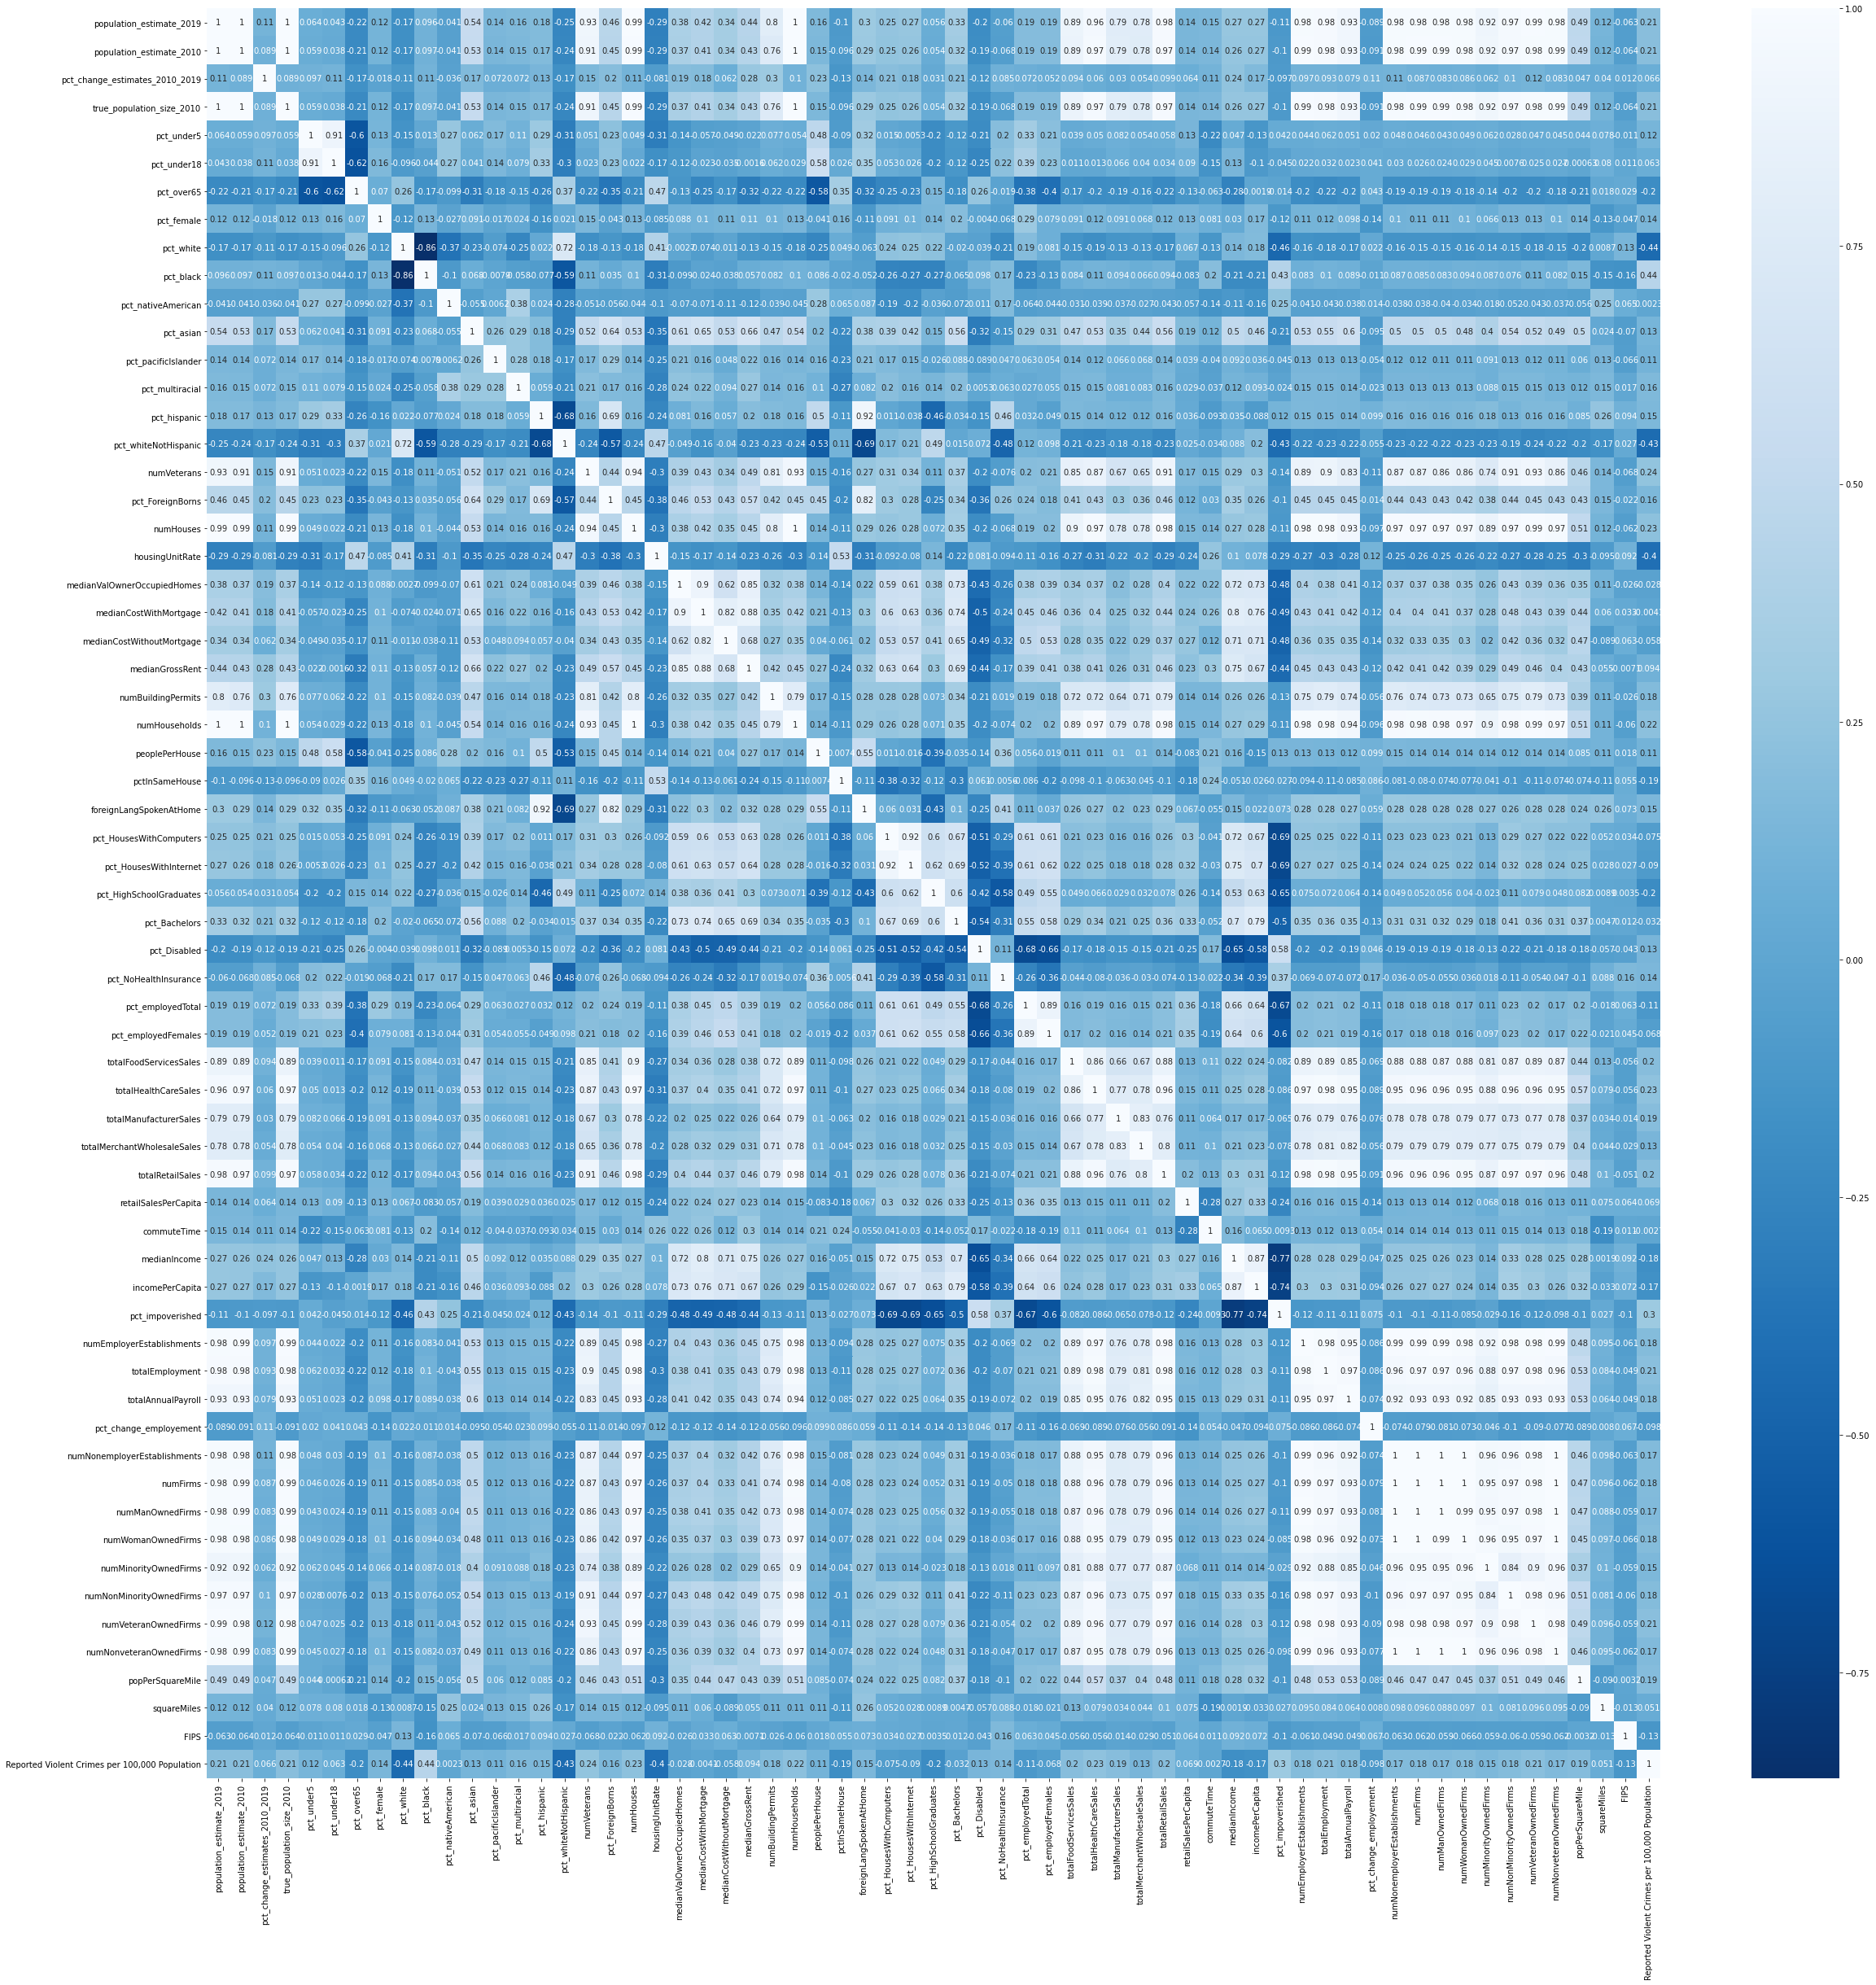

In [ ]:
plt.subplots(figsize=(40,40))
sb.heatmap(corr_matrix, annot =True, cmap='Blues_r')

In [ ]:
# Print out the highest correlations between variables to get a handle on feature engineering ideas 
for i in range(corr_matrix.shape[0]):
   for j in range(corr_matrix.shape[1]):
     if corr_matrix.iloc[i,j] > .7 and corr_matrix.columns[i] != corr_matrix.index[j]:
       print(corr_matrix.columns[i], "vs.", corr_matrix.index[j], "\n", corr_matrix.iloc[i,j])

population_estimate_2019 vs. population_estimate_2010 
 0.9976666175216534
population_estimate_2019 vs. true_population_size_2010 
 0.9976676601553692
population_estimate_2019 vs. numVeterans 
 0.9267338608362145
population_estimate_2019 vs. numHouses 
 0.9944987669597367
population_estimate_2019 vs. numBuildingPermits 
 0.7959424765940903
population_estimate_2019 vs. numHouseholds 
 0.9963460230365146
population_estimate_2019 vs. totalFoodServicesSales 
 0.8922682057257703
population_estimate_2019 vs. totalHealthCareSales 
 0.9631698462954054
population_estimate_2019 vs. totalManufacturerSales 
 0.7863901034472378
population_estimate_2019 vs. totalMerchantWholesaleSales 
 0.784160050093416
population_estimate_2019 vs. totalRetailSales 
 0.9753909479401872
population_estimate_2019 vs. numEmployerEstablishments 
 0.9848337045529187
population_estimate_2019 vs. totalEmployment 
 0.978001244596799
population_estimate_2019 vs. totalAnnualPayroll 
 0.9330567991976215
population_estimate_201

In [ ]:
# Get the data again and drop all of the columns we do not want to use in our model
census_crime_data = pd.read_csv('fully_cleaned_CENSUS_&_CRIME_DATA.csv', na_values=['', ' '])
crime_demo_data = census_crime_data.drop(['Unnamed: 0','PLACE','Annual Avg Violent Crimes','Z-Score'], axis='columns')
crime_demo_data.isna().sum()

population_estimate_2019                            0
population_estimate_2010                            0
pct_change_estimates_2010_2019                      0
true_population_size_2010                           0
pct_under5                                          0
                                                 ... 
numNonveteranOwnedFirms                             0
popPerSquareMile                                    0
squareMiles                                         0
FIPS                                                0
Reported Violent Crimes per 100,000 Population    175
Length: 63, dtype: int64

# 2. Feature Engineering

---



In [ ]:
ccd = pd.read_csv('fully_cleaned_CENSUS_&_CRIME_DATA.csv')
ccd

,Unnamed: 0,PLACE,population_estimate_2019,population_estimate_2010,pct_change_estimates_2010_2019,true_population_size_2010,pct_under5,pct_under18,pct_over65,pct_female,pct_white,pct_black,pct_nativeAmerican,pct_asian,pct_pacificIslander,pct_multiracial,pct_hispanic,pct_whiteNotHispanic,numVeterans,pct_ForeignBorns,numHouses,housingUnitRate,medianValOwnerOccupiedHomes,medianCostWithMortgage,medianCostWithoutMortgage,medianGrossRent,numBuildingPermits,numHouseholds,peoplePerHouse,pctInSameHouse,foreignLangSpokenAtHome,pct_HousesWithComputers,pct_HousesWithInternet,pct_HighSchoolGraduates,pct_Bachelors,pct_Disabled,pct_NoHealthInsurance,pct_employedTotal,pct_employedFemales,totalFoodServicesSales,totalHealthCareSales,totalManufacturerSales,totalMerchantWholesaleSales,totalRetailSales,retailSalesPerCapita,commuteTime,medianIncome,incomePerCapita,pct_impoverished,numEmployerEstablishments,totalEmployment,totalAnnualPayroll,pct_change_employement,numNonemployerEstablishments,numFirms,numManOwnedFirms,numWomanOwnedFirms,numMinorityOwnedFirms,numNonMinorityOwnedFirms,numVeteranOwnedFirms,numNonveteranOwnedFirms,popPerSquareMile,squareMiles,FIPS,Annual Avg Violent Crimes,"Reported Violent Crimes per 100,000 Population",Z-Score
0,0,"Kiowa County, Oklahoma",8708.0,9446.0,7.8,9446.0,7.2,24.0,19.7,50.1,82.6,4.5,7.9,0.3,0.1,4.7,11.9,73.9,671.0,2.0,5129.0,69.6,62100.0,879.0,312.0,574.0,58.0,3772.0,2.33,82.6,7.6,79.3,69.5,83.7,17.4,15.1,16.7,58.5,50.4,43059.0,30628.0,737794.0,240261.0,58258.0,6258.0,21.4,38209.0,20888.0,16.9,180.0,1353.0,41883.0,4.3,598.0,883.0,457.0,239.0,56.0,774.0,80.0,734.0,9.3,1015.23,40075.0,17.0,180.0,-0.40
1,1,"Latimer County, Oklahoma",10073.0,11156.0,9.7,11154.0,6.1,21.8,22.1,49.5,65.4,1.3,23.6,0.6,0.0,9.0,4.2,63.3,960.0,1.3,5040.0,70.4,86200.0,898.0,297.0,574.0,11.0,4042.0,2.50,84.0,3.1,78.3,64.0,87.8,17.2,16.1,17.7,49.7,46.5,43059.0,22972.0,737794.0,73480.0,52519.0,4766.0,24.1,42363.0,23842.0,17.9,155.0,3312.0,149811.0,2.4,794.0,936.0,528.0,272.0,163.0,697.0,135.0,734.0,15.4,722.08,40077.0,23.0,214.0,-0.18
2,2,"Le Flore County, Oklahoma",49853.0,50382.0,1.0,50384.0,6.1,23.9,18.3,49.8,76.8,2.0,14.1,0.7,0.2,6.1,7.2,71.0,3930.0,3.4,22203.0,71.4,88400.0,949.0,320.0,637.0,61.0,18367.0,2.64,86.5,5.9,76.5,65.6,82.5,15.1,16.3,20.7,51.7,47.8,43059.0,202838.0,737794.0,240261.0,406799.0,8157.0,24.9,39769.0,20656.0,22.6,790.0,7034.0,214810.0,1.0,3084.0,3789.0,1937.0,1282.0,601.0,3024.0,447.0,3159.0,31.7,1589.21,40079.0,126.0,255.0,0.08
3,3,"Lincoln County, Oklahoma",34877.0,34274.0,1.8,34273.0,5.7,23.5,18.6,50.2,84.5,2.0,7.3,0.4,0.1,5.7,3.6,81.9,2961.0,1.0,15442.0,79.1,107700.0,1015.0,336.0,667.0,8.0,12821.0,2.69,91.8,1.5,80.7,62.2,86.3,15.1,13.9,17.5,55.3,48.7,22632.0,101006.0,231515.0,117305.0,239108.0,6994.0,29.0,49362.0,24454.0,14.7,574.0,5553.0,225279.0,2.8,2477.0,2368.0,1265.0,814.0,379.0,1927.0,309.0,1975.0,36.0,952.31,40081.0,73.0,209.0,-0.21
4,4,"Logan County, Oklahoma",48011.0,41854.0,14.7,41848.0,5.7,22.6,16.4,50.4,82.8,8.1,3.7,0.7,0.1,4.6,6.7,77.4,3460.0,2.9,17574.0,79.6,160700.0,1385.0,394.0,747.0,14.0,15665.0,2.81,86.3,4.8,86.1,77.1,90.2,27.6,9.5,14.9,62.3,55.3,37294.0,101006.0,97588.0,26267.0,343943.0,7877.0,27.7,62035.0,29387.0,10.4,862.0,6780.0,237346.0,5.3,4022.0,4007.0,2265.0,1159.0,707.0,3120.0,447.0,3349.0,56.3,743.83,40083.0,80.0,173.0,-0.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2979,2979,"Owen County, Kentucky",10901.0,10837.0,0.6,10841.0,5.1,21.9,19.1,50.1,97.2,1.2,0.3,0.2,0.0,1.1,2.7,94.8,786.0,0.0,5765.0,73.1,99400.0,1071.0,370.0,636.0,1.0,3921.0,2.72,87.6,1.1,75.3,58.3,82.6,9.9,16.1,7.2,50.9,47.5,43059.0,23013.0,737794.0,18342.0,62217.0,5780.0,32.0,45338.0,23045.0,15.8,118.0,1055.0,35571.0,17.5,756.0,847.0,446.0,275.0,41.0,790.0,85.0,684.0,30.9,351.10,21187.0,2.0,19.0

In [ ]:
# Feature Engineering ("per capita")
ccd = ccd.assign(veteransPerCapita=ccd.numVeterans/ccd.true_population_size_2010, housesPerCapita=ccd.numHouses/ccd.true_population_size_2010, householdsPerCapita = ccd.numHouseholds/ccd.true_population_size_2010, buildingPermitsPerCapita = ccd.numBuildingPermits/ccd.true_population_size_2010, foodServicesSalesPerCapita=ccd.totalFoodServicesSales/ccd.true_population_size_2010, healthCareSalesPerCapita=ccd.totalHealthCareSales/ccd.true_population_size_2010, manufacturerSalesPerCapita=ccd.totalManufacturerSales/ccd.true_population_size_2010, merchantWholesaleSalesPerCapita=ccd.totalMerchantWholesaleSales/ccd.true_population_size_2010, retailSalesPerCapita=ccd.totalRetailSales/ccd.true_population_size_2010, employerEstablishmentsPerCapita=ccd.numEmployerEstablishments/ccd.true_population_size_2010, nonemployerEstablishmentsPerCapita=ccd.numNonemployerEstablishments/ccd.true_population_size_2010, firmsPerCapita=ccd.numFirms/ccd.true_population_size_2010, manOwnedFirmsPerCapita=ccd.numManOwnedFirms/ccd.true_population_size_2010, womanOwnedFirmsPerCapita=ccd.numWomanOwnedFirms/ccd.true_population_size_2010, minorityOwnedFirmsPerCapita=ccd.numMinorityOwnedFirms/ccd.true_population_size_2010, nonMinorityOwnedFirmsPerCapita=ccd.numNonMinorityOwnedFirms/ccd.true_population_size_2010, veteranOwnedFirmsPerCapita=ccd.numVeteranOwnedFirms/ccd.true_population_size_2010, nonVeteranOwnedFirmsPerCapita=ccd.numNonveteranOwnedFirms/ccd.true_population_size_2010)

In [ ]:
# Feature Engineering ("pct", other)
ccd = ccd.assign(housesPerHousehold=ccd.numHouses/ccd.numHouseholds, buildingPermitsPerHouse=ccd.numBuildingPermits/ccd.numHouses, pctManOwnedFirms=ccd.numManOwnedFirms/ccd.numFirms, pctWomanOwnedFirms=ccd.numWomanOwnedFirms/ccd.numFirms, pctMinorityOwnedFirms=ccd.numMinorityOwnedFirms/ccd.numFirms, pctNonMinorityOwnedFirms=ccd.numNonMinorityOwnedFirms/ccd.numFirms, pctVeteranOwnedFirms=ccd.numVeteranOwnedFirms/ccd.numFirms, pctNonVeteranOwnedFirms = ccd.numNonveteranOwnedFirms/ccd.numFirms)

In [ ]:
# Export Feature Engineered Crime and Census Data to the drive folder 
ccd.to_csv('/gdrive/My Drive/ML4VA/feature_engineered_CENSUS_&_CRIME_DATA.csv')

# 3. Scale and Split Data

---



The first thing we will be doing is to scale and split the data. The first model we will build will be for the entire United States of America where the train and test data is randomly sampled from across the country. The second model will be trained on US county data and tested on the state of Virginia. 

In [ ]:
print("Len prior to dropping NA values:",len(crime_demo_data))
crime_demo_data = crime_demo_data.dropna(axis='index')
print("Len after dropping NA values:", len(crime_demo_data))
crime_demo_data = crime_demo_data.drop(['FIPS'], axis='columns')
crime_demo_data = crime_demo_data.reset_index(drop=True)

Len prior to dropping NA values: 2984
Len after dropping NA values: 2809


In [ ]:
# Bin the data to allow for stratified shuffle split to work 
crime_demo_data['crime_cat'] = pd.cut(x=crime_demo_data['Reported Violent Crimes per 100,000 Population'],
                                      bins=7,
                                      labels=[1,2,3,4,5,6,7])

# See how many values you have in each of the binned cut columns 
crime_demo_data['crime_cat'].value_counts()

# Split the data into test and train sets 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(crime_demo_data, crime_demo_data['crime_cat']):
    strat_train_set = crime_demo_data.loc[train_index]
    strat_test_set = crime_demo_data.loc[test_index]

In [ ]:
# Set aside your labels 
test_label = strat_test_set['Reported Violent Crimes per 100,000 Population']
train_label = strat_train_set['Reported Violent Crimes per 100,000 Population']

# And drop them from your split data
strat_test_set = strat_test_set.drop(['Reported Violent Crimes per 100,000 Population'], axis='columns')
strat_train_set = strat_train_set.drop(['Reported Violent Crimes per 100,000 Population'], axis='columns')

In [ ]:
# Set up your transformation pipeline
scale_data = Pipeline([
                        ('std_scaler', StandardScaler()),
                  ])

# Scale your test and train data so that you can run better models with gradient descent. 
scaled_crime = scale_data.fit_transform(strat_train_set) 
model_train = pd.DataFrame(scaled_crime)

scaled_crime = scale_data.fit_transform(strat_test_set) 
model_test = pd.DataFrame(scaled_crime)

Split data by VA va the rest of the united states and run through the same process as above


In [ ]:
census_crime_data = pd.read_csv('fully_cleaned_CENSUS_&_CRIME_DATA.csv', na_values=['', ' '])
census_crime_data = census_crime_data.dropna(axis='index')
census_crime_data = census_crime_data.reset_index(drop=True)
census_crime_data = census_crime_data.drop(['Unnamed: 0','Annual Avg Violent Crimes','Z-Score','FIPS'], axis='columns')

In [ ]:
# Subset the crime and county demographic data by state 
def split_comma(X):
  return str.strip(str(X).split(',')[1])

list_state = np.array(list(census_crime_data['PLACE'].apply(split_comma)))
census_crime_data = census_crime_data.drop(['PLACE'], axis='columns')
va_data = census_crime_data[list_state == 'Virginia']
other_data = census_crime_data[list_state != 'Virginia']

In [ ]:
# Seperate the labels from the rest of the data
va_labs = va_data['Reported Violent Crimes per 100,000 Population']
other_lab = other_data['Reported Violent Crimes per 100,000 Population']

va_data = va_data.drop(['Reported Violent Crimes per 100,000 Population'], axis='columns')
other_data = other_data.drop(['Reported Violent Crimes per 100,000 Population'], axis='columns')

In [ ]:
# Scale the data 
scale_va = scale_data.fit_transform(va_data)
scale_other = scale_data.fit_transform(other_data)

va_test = pd.DataFrame(scale_va)
other_train = pd.DataFrame(scale_other)

# 4. Linear Regression Model

---



The first model here will be used to predict crime levels all across the United States. The training and testing sets have been taken from the comprehensive dataset of all of the counties in the United States. 

In [ ]:
# Set up your linear regression model and train it
lin_reg = LinearRegression()
lin_reg.fit(model_train, train_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
crime_predictions = lin_reg.predict(model_test)
lin_mse = mean_squared_error(test_label, crime_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

77.36976278314363

In [ ]:
print("The max reported crime count is: ", max(crime_demo_data['Reported Violent Crimes per 100,000 Population']))
print("The min reported crime count is: ",min(crime_demo_data['Reported Violent Crimes per 100,000 Population']))
print("The average crime count is: ", sum(crime_demo_data['Reported Violent Crimes per 100,000 Population']/len(crime_demo_data['Reported Violent Crimes per 100,000 Population'])))
print("The standard deviation of the crime count is: ",statistics.stdev(crime_demo_data['Reported Violent Crimes per 100,000 Population']))

The max reported crime count is:  1499.0
The min reported crime count is:  0.0
The average crime count is:  243.56283374866496
The standard deviation of the crime count is:  182.59831988396178


The second model will be trained on US county data and tested on the State of Virginia.

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(other_train, other_lab)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
va_crime_predictions = lin_reg.predict(va_test)
lin_mse = mean_squared_error(va_labs, va_crime_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

274.7649552331351

# 5. Stochastic Gradient Descent Model 

---



In [ ]:
sgd_reg = SGDRegressor()
sgd_reg.fit(model_train, train_label)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
crime_predictions = sgd_reg.predict(model_test)
lin_mse = mean_squared_error(test_label, crime_predictions)
lin_rmse = np.sqrt(lin_mse)
print("Root mean square error: ",lin_rmse)

Root mean square error:  64.78515981778969


Looks like we just slightly improved upon the performance of the linear regression model. 

# 6. Random Forest Model 

---



In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

nest = [100,250,500]

params = {"n_estimators": nest,
          "criterion" : ["mse"],
          "n_jobs" : [4],
          "bootstrap" : ["True","False"],
          "max_depth" : [10,25,100]
          }


tree_grid_search = GridSearchCV(RandomForestRegressor(), params, refit  = True, verbose = 5)

tree_grid_search.fit(model_train,train_label)
rand = tree_grid_search.predict(model_test)
rand_mse = mean_squared_error(test_label, rand)
rand_rmse = np.sqrt(rand_mse)


print("Root mean square error: ",rand_rmse)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] bootstrap=True, criterion=mse, max_depth=10, n_estimators=100, n_jobs=4 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, criterion=mse, max_depth=10, n_estimators=100, n_jobs=4, score=0.909, total=   3.1s
[CV] bootstrap=True, criterion=mse, max_depth=10, n_estimators=100, n_jobs=4 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.1s remaining:    0.0s


[CV]  bootstrap=True, criterion=mse, max_depth=10, n_estimators=100, n_jobs=4, score=0.921, total=   2.0s
[CV] bootstrap=True, criterion=mse, max_depth=10, n_estimators=100, n_jobs=4 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.1s remaining:    0.0s


[CV]  bootstrap=True, criterion=mse, max_depth=10, n_estimators=100, n_jobs=4, score=0.916, total=   2.0s
[CV] bootstrap=True, criterion=mse, max_depth=10, n_estimators=100, n_jobs=4 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.1s remaining:    0.0s


[CV]  bootstrap=True, criterion=mse, max_depth=10, n_estimators=100, n_jobs=4, score=0.911, total=   2.1s
[CV] bootstrap=True, criterion=mse, max_depth=10, n_estimators=100, n_jobs=4 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.2s remaining:    0.0s


[CV]  bootstrap=True, criterion=mse, max_depth=10, n_estimators=100, n_jobs=4, score=0.908, total=   2.0s
[CV] bootstrap=True, criterion=mse, max_depth=10, n_estimators=250, n_jobs=4 
[CV]  bootstrap=True, criterion=mse, max_depth=10, n_estimators=250, n_jobs=4, score=0.908, total=   4.8s
[CV] bootstrap=True, criterion=mse, max_depth=10, n_estimators=250, n_jobs=4 
[CV]  bootstrap=True, criterion=mse, max_depth=10, n_estimators=250, n_jobs=4, score=0.921, total=   4.9s
[CV] bootstrap=True, criterion=mse, max_depth=10, n_estimators=250, n_jobs=4 
[CV]  bootstrap=True, criterion=mse, max_depth=10, n_estimators=250, n_jobs=4, score=0.917, total=   4.8s
[CV] bootstrap=True, criterion=mse, max_depth=10, n_estimators=250, n_jobs=4 
[CV]  bootstrap=True, criterion=mse, max_depth=10, n_estimators=250, n_jobs=4, score=0.911, total=   4.9s
[CV] bootstrap=True, criterion=mse, max_depth=10, n_estimators=250, n_jobs=4 
[CV]  bootstrap=True, criterion=mse, max_depth=10, n_estimators=250, n_jobs=4, s

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  9.9min finished


Root mean square error:  60.38123700909061


In [44]:
print(tree_grid_search.best_params_)

{'bootstrap': 'False', 'criterion': 'mse', 'max_depth': 10, 'n_estimators': 250, 'n_jobs': 4}


In [ ]:
from graphviz import Source
from sklearn.tree import export_graphviz
print(type(model_test))
#CHAPTER_ID = "decision_trees"
#PROJECT_ROOT_DIR = "."
#IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
export_graphviz(
        tree,
        out_file="/gdrive/My Drive/ML4VA/treeDiagram",
        feature_names=model_test.columns,
        #class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file("/gdrive/My Drive/ML4VA/treeDiagram")

# 7. Clustering Data

---



In [45]:
# http://www.diva-gis.org/datadown
# Upload .dbf, .shp, .prj and .shx files 
from google.colab import files
files.upload()

# Make a directory and move all of the files to the directory 
%mkdir '/gdrive/My Drive/ML4VA/shapefiles'
!mv '/content/USA_adm2.shp' '/gdrive/My Drive/ML4VA/shapefiles'
!mv '/content/USA_adm2.shx' '/gdrive/My Drive/ML4VA/shapefiles'
!mv '/content/USA_adm2.prj' '/gdrive/My Drive/ML4VA/shapefiles'
!mv '/content/USA_adm2.dbf' '/gdrive/My Drive/ML4VA/shapefiles'

KeyboardInterrupt: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


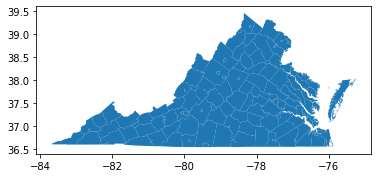

In [46]:
# Read in crime data
crime_data = pd.read_csv('/gdrive/My Drive/ML4VA/fully_cleaned_CENSUS_&_CRIME_DATA.csv')

# Subset crime data to only include virginia 
def split_comma(X):
  return str(X).split(',')

list_state = np.array(list(crime_data['PLACE'].apply(split_comma)))
va_data = crime_data.iloc[np.where(list_state==' Virginia')[0]]

# Read in the US geo data, subset va geo data 
US_geo_data = gpd.read_file('/gdrive/My Drive/ML4VA/shapefiles/USA_adm2.shp')
VA_shp_data = US_geo_data[US_geo_data['NAME_1'] == 'Virginia']
VA_shp_data = VA_shp_data.drop(['ID_0','NAME_0','ID_1','ID_2','TYPE_2','ENGTYPE_2','NL_NAME_2','VARNAME_2','ISO','NAME_1'], axis='columns')

# Merge VA crime data with VA geo data
def pop_em(X):
  X = X.split(',')[0]
  X = X.split(' ')
  X.pop()
  X = ' '.join(X)
  return X

va_data['County'] = va_data['PLACE'].apply(pop_em)
va_data = va_data.merge(VA_shp_data, how='left', left_on='County', right_on='NAME_2')

# Plot va_data
VA_shp_data.plot()

Text(0.5, 1.0, 'Reported Violent Crimes per 100,000 Population in Virginia')

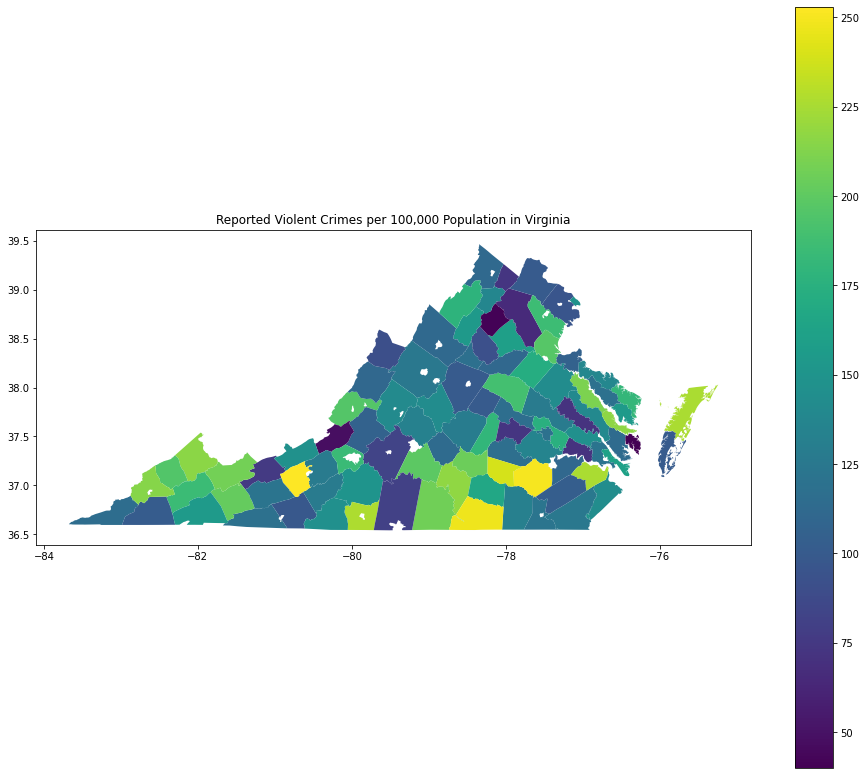

In [47]:
# Plot VA chloropleth map using crime as the variable 
geo_data = gpd.GeoDataFrame(va_data.loc[:,['Reported Violent Crimes per 100,000 Population','Annual Avg Violent Crimes','geometry']])

fig = geo_data.plot(
          #column = 'Annual Avg Violent Crimes', 
          column = 'Reported Violent Crimes per 100,000 Population',
          legend = True, 
          figsize = (16,14)
        )

fig.set_title('Reported Violent Crimes per 100,000 Population in Virginia')

Text(0, 0.5, 'Error Level (inertia)')

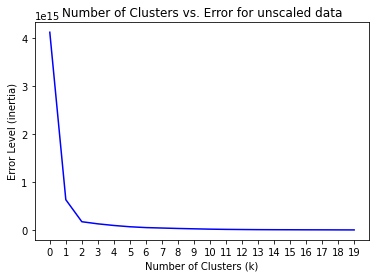

In [48]:
# Drop all of the columns you do not want to include in your clustering 
X = va_data.drop(['geometry','NAME_2','County','Z-Score','FIPS','PLACE','Unnamed: 0'], axis='columns')
X.head(5)

# Cluster the data with 5 clusters 
from sklearn.cluster import KMeans
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(X)

# Find the elbow of the cluster for unscaled data
error = []
ith = []
for i in range(20):
  kmeans = KMeans(n_clusters=i+1, random_state=42, n_init=10)
  y_pred = kmeans.fit_predict(X)
  error.append(kmeans.inertia_)
  ith.append(i)

fig, ax = plt.subplots() 
ax.plot(ith, error, 'b')
ax.set_xticks(list(range(20)))
ax.set_title('Number of Clusters vs. Error for unscaled data')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Error Level (inertia)')

Text(0, 0.5, 'Error Level (inertia)')

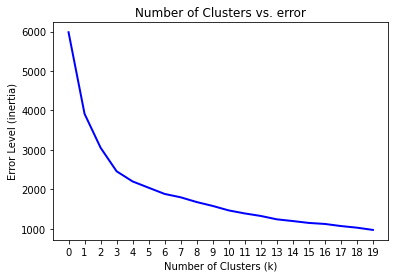

In [49]:
X_scaled = StandardScaler().fit_transform(X)
# Find the elbow of the cluster for unscaled data
error = []
ith = []
for i in range(20):
  kmeans = KMeans(n_clusters=i+1, random_state=42, n_init=10)
  y_pred = kmeans.fit_predict(X_scaled)
  error.append(kmeans.inertia_)
  ith.append(i)

fig, ax = plt.subplots() 
ax.plot(ith, error, color="b", linewidth = 2)
ax.set_xticks(list(range(20)))
ax.set_title('Number of Clusters vs. error')
ax.set_xlabel('Number of Clusters (k)')
ax.set_ylabel('Error Level (inertia)')

In [50]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
y_pred = kmeans.fit_predict(X)

# Append the clusters column onto the x-data
X_plot = X
X_plot['clusters'] = y_pred

# Add the geometry polygon values back into the va_data 
X_plot['geometry'] = va_data['geometry']
X_plot[['clusters','geometry']]

,clusters,geometry
0,0,"MULTIPOLYGON (((-75.37417 37.85695, -75.37527 ..."
1,0,"POLYGON ((-78.30585 38.00703, -78.48742 37.801..."
2,0,"POLYGON ((-79.67441 37.76433, -79.81663 37.801..."
3,0,"POLYGON ((-77.85803 37.41931, -77.85926 37.416..."
4,0,"POLYGON ((-78.87463 37.54257, -78.88399 37.533..."
...,...,...
90,0,"POLYGON ((-82.33295 36.71196, -82.32391 36.715..."
91,0,"MULTIPOLYGON (((-76.72335 38.11907, -76.72309 ..."
92,0,"POLYGON ((-82.39923 36.88140, -82.40098 36.885..."
93,0,"POLYGON ((-81.38007 36.95195, -81.37292 36.965..."


Text(0.5, 1.0, 'Clustering VA counties by demographic similarity with 3 clusters')

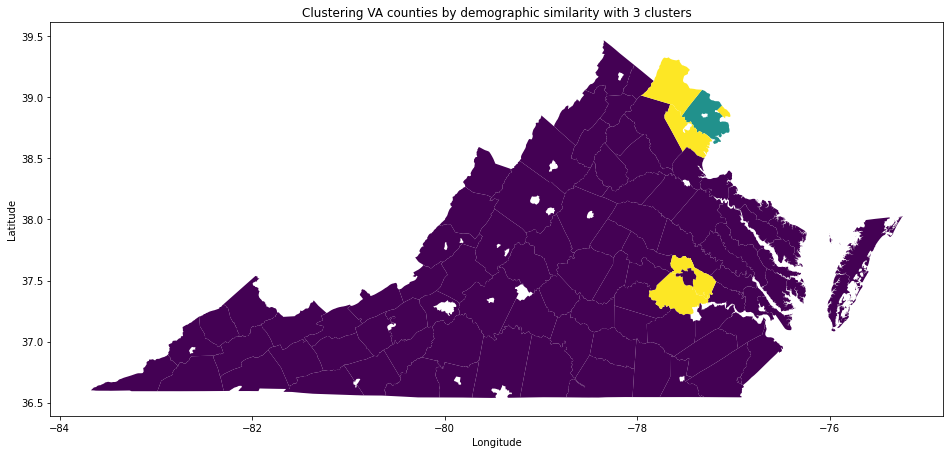

In [51]:
# Plot the clusters vs the geography
geo_data = gpd.GeoDataFrame(X_plot[['clusters','geometry']])

fig = geo_data.plot(
          #column = 'Annual Avg Violent Crimes', 
          column = 'clusters',
          legend = False, 
          figsize = (16,14)
        )
fig.set_xlabel('Longitude')
fig.set_ylabel('Latitude')
fig.set_title('Clustering VA counties by demographic similarity with 3 clusters')

# Reflection

---

